In [130]:
%matplotlib inline

import os
import yaml

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import WMAP9

import grizli
import grizli.catalog
from grizli import utils

from scipy.optimize import curve_fit
import pandas as pd

import eazy

print(f'grizli version: {grizli.__version__}')
print(f'eazy-py version: {eazy.__version__}')

grizli version: 1.11.2
eazy-py version: 0.6.8


### Set field & path
`abell2744clu` = Abell 2744 GLASS + UNCOVER + DD-2756

`gds` = GOODS-South

In [2]:
field = 'abell2744clu-grizli-v7.0' 
url_path = 'https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7'

## Raw photometry

NB: All photometry given in `fnu` flux densities with units of `microJansky` (AB zeropoint = 23.9).

In [3]:
phot = utils.read_catalog(f'{url_path}/{field}-fix_phot_apcorr.fits') # changed 
print(type(phot))
phot.columns

<class 'grizli.utils.GTable'>


<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_aper_0','clearp-f356w_flux_aper_1','clearp-f356w_fluxerr_aper_1','clearp-

### Metadata

In [4]:
# General data of source detection
for i, k in enumerate(phot.meta):
    print(f'{k:>36} = {phot.meta[k]}')
    if i > 70:
        print('...')
        break

                             VERSION = 1.2.1
                             MINAREA = 9
                               CLEAN = True
                             DEBCONT = 0.001
                            DEBTHRSH = 32
                         FILTER_TYPE = conv
                           THRESHOLD = 1.5
                            KRONFACT = 2.5
                               KRON0 = 2.4
                               KRON1 = 3.8
                             MINKRON = 8.75000000000009
                            TOTCFILT = F140W
                            TOTCWAVE = 13922.907
                                  ZP = 28.9
                                PLAM = 13922.907
                                 FNU = 1e-08
                                FLAM = 1.4737148e-20
                              UJY2DN = 99.99395614709495
                            DRZ_FILE = abell2744clu-grizli-v7.0-ir_drc_sci.
                            WHT_FILE = abell2744clu-grizli-v7.0-ir_drc_wht.
                 

### Photometric apertures

In [5]:
for i, k in enumerate(phot.meta):
    if k.startswith('APER_'):
        aper_index = k[-1]
        print(f"Aperture index {aper_index}: *diameter* = {phot.meta[k]:4.1f} pixels = {phot.meta[k.replace('APER','ASEC')]:.2f} arcsec")

# Some observers use large apertures for their measurements to account for seeing, tracking, 
# and focus variations, while others use small apertures and apply aperture corrections (how do we choose here?)

Aperture index 0: *diameter* =  9.0 pixels = 0.36 arcsec
Aperture index 1: *diameter* = 12.5 pixels = 0.50 arcsec
Aperture index 2: *diameter* = 17.5 pixels = 0.70 arcsec
Aperture index 3: *diameter* = 25.0 pixels = 1.00 arcsec


In [6]:
# Columns for a particular filter + aperture
# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

aper_index = '1' 

cols = []

for k in phot.colnames:
    if k.startswith('f606w') & k.endswith(aper_index):
        cols.append(k)
        
phot[cols].info()

<GTable length=47888>
        name          dtype  unit    class     n_bad
-------------------- ------- ---- ------------ -----
   f606w_flux_aper_1 float64  uJy MaskedColumn  8020
f606w_fluxerr_aper_1 float64  uJy MaskedColumn  8020
   f606w_flag_aper_1   int16      MaskedColumn     0
    f606w_bkg_aper_1 float64  uJy MaskedColumn  8023
   f606w_mask_aper_1 float64            Column     0
        f606w_corr_1 float64  uJy MaskedColumn     2
       f606w_ecorr_1 float64  uJy MaskedColumn     2
         f606w_tot_1 float64  uJy MaskedColumn     2
        f606w_etot_1 float64  uJy MaskedColumn     2


### Photometric bands

- NIRCam filters generally have "clear" in the filter name, which is the element in the `pupil` wheel.
- Filters that start with `clearp` are generally the long-wavelength NIRISS filters.
- Filters with names that end in `wn` are the NIRISS versions, e.g., `f200wn-clear` for NIRISS and `f200w-clear` for NIRCam
- HST filters ending in "u" are the WFC3/UVIS versions, e.g., `f814wu`

In [7]:
# bands 
count = 0
for k in phot.colnames:
    if k.endswith('_flux_aper_1'):
        count += 1
        print(f"{count:>2} {k.split('_flux')[0]}")

 1 clearp-f356w
 2 clearp-f444w
 3 f090w
 4 f105w
 5 f115w
 6 f115wn
 7 f125w
 8 f140w
 9 f150w
10 f150wn
11 f160w
12 f200w
13 f200wn
14 f277w
15 f356w
16 f410m
17 f435w
18 f444w
19 f475w
20 f606w
21 f775w
22 f814w


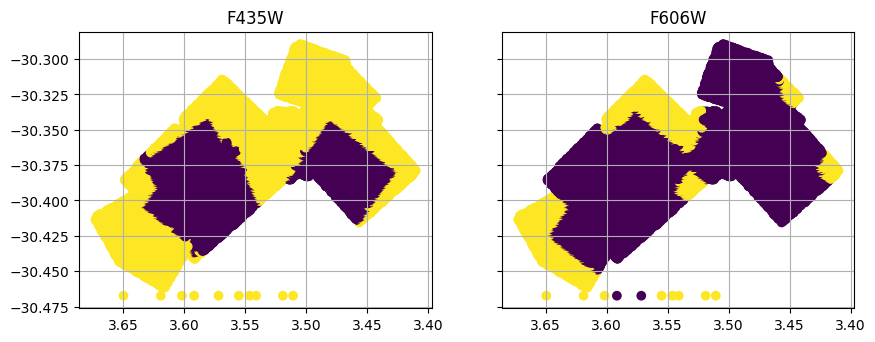

In [8]:
# Missing data are *masked* (?)

# bands in the HFF survey that cover the optical-IR: F435, F606, F814, F105, F140

fig, axes = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)

axes[0].scatter(phot['ra'], phot['dec'], c=phot['f435w_flux_aper_1'].mask)
axes[0].set_title('F435W') # what are (JADES/FRESCO)?
axes[1].scatter(phot['ra'], phot['dec'], c=phot['f606w_flux_aper_1'].mask)
axes[1].set_title('F606W')

axes[0].set_xlim(*axes[0].get_xlim()[::-1])
cosd = np.cos(np.nanmedian(phot['dec'])/180*np.pi)
for ax in axes:
    ax.set_aspect(1./cosd)
    ax.grid()

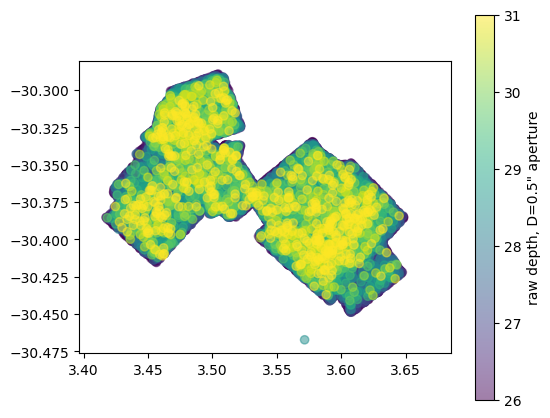

In [9]:
# 5-sigma depth in the D=0.5" aperture
depth = 23.9 - 2.5*np.log10(phot['f606w_flux_aper_1']*5) # how do you get 23.9?
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.set_aspect(1./cosd)
so = np.argsort(depth)
sc = ax.scatter(phot['ra'][so], phot['dec'][so], c=depth[so], vmin=26, vmax=31, alpha=0.5)
ax.set_xlim(*axes[0].get_xlim()[::-1])
cb = plt.colorbar(sc)
cb.set_label('raw depth, D=0.5" aperture')

### Point sources

Text(0, 0.5, 'flux_radius')

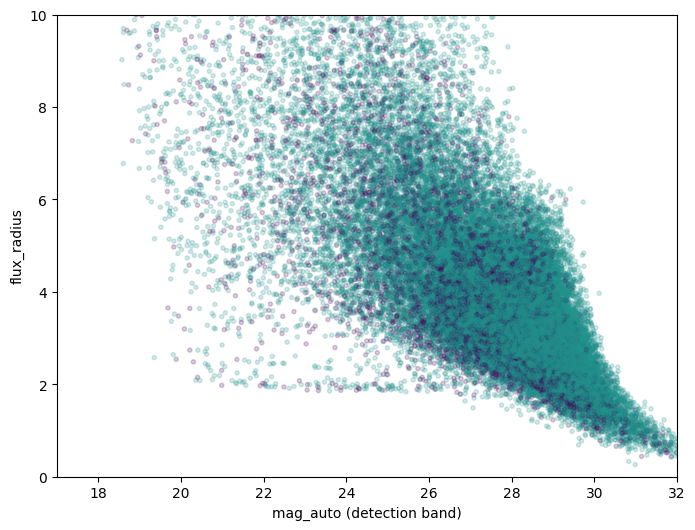

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8, 6))
in_jades = ~phot['f606w_flux_aper_1'].mask
ax.scatter(phot['mag_auto'], phot['flux_radius'], alpha=0.2, c=in_jades, vmin=0, vmax=2, cmap='viridis', marker='.')
ax.set_ylim(0,10); ax.set_xlim(17, 32)

ax.set_xlabel('mag_auto (detection band)'); ax.set_ylabel('flux_radius') # limit from -1 because below that pixels are so small it gets noise (half light radius)


In [11]:
phot.columns

<TableColumns names=('id','thresh','npix','tnpix','xmin','xmax','ymin','ymax','x','y','x2_image','y2_image','xy_image','errx2','erry2','errxy','a_image','b_image','theta_image','cxx_image','cyy_image','cxy_image','cflux','flux','cpeak','peak','xcpeak','ycpeak','xpeak','ypeak','flag','x_image','y_image','number','ra','dec','x_world','y_world','flux_iso','fluxerr_iso','area_iso','mag_iso','kron_radius','kron_rcirc','flux_auto','fluxerr_auto','bkg_auto','flag_auto','area_auto','flux_radius_flag','flux_radius_20','flux_radius','flux_radius_90','tot_corr','mag_auto','magerr_auto','flux_aper_0','fluxerr_aper_0','flag_aper_0','bkg_aper_0','mask_aper_0','flux_aper_1','fluxerr_aper_1','flag_aper_1','bkg_aper_1','mask_aper_1','flux_aper_2','fluxerr_aper_2','flag_aper_2','bkg_aper_2','mask_aper_2','clearp-f356w_flux_aper_0','clearp-f356w_fluxerr_aper_0','clearp-f356w_flag_aper_0','clearp-f356w_bkg_aper_0','clearp-f356w_mask_aper_0','clearp-f356w_flux_aper_1','clearp-f356w_fluxerr_aper_1','clearp-

## RA vs Dec

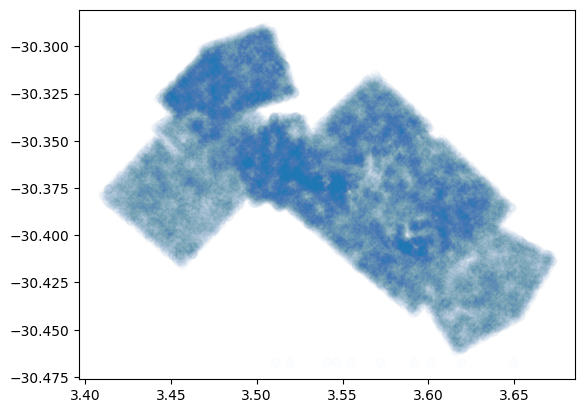

In [12]:
# RA vs Dec
plt.scatter(phot['ra'], phot['dec'], vmin=3.4, vmax=3.6, alpha=0.01)
# plt.scatter(phot['x_world'], phot['y_world'], vmin=3.4, vmax=3.6, alpha=0.01) # <-- celestial coordinates

# Photometric redshifts

In [173]:
root + '.eazypy.zout.fits'

'abell2744clu-grizli-v7.0-fix.eazypy.zout.fits'

In [16]:
import eazy.hdf5

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

root = f'{field}-fix'

self = eazy.hdf5.initialize_from_hdf5(h5file=root+'.eazypy.h5')

zout = utils.read_catalog(root+'.eazypy.zout.fits')
self.cat = utils.read_catalog(root+'_phot_apcorr.fits')
cat = self.cat

Read default param file: /home/codespace/.python/current/lib/python3.10/site-packages/eazy/data/zphot.param.default
CATALOG_FILE is a table
   >>> NOBJ = 47888
f090w_tot_1 f090w_etot_1 (363): jwst_nircam_f090w
f105w_tot_1 f105w_etot_1 (202): hst/wfc3/IR/f105w.dat
f115w_tot_1 f115w_etot_1 (364): jwst_nircam_f115w
f115wn_tot_1 f115wn_etot_1 (309): niriss-f115w
f125w_tot_1 f125w_etot_1 (203): hst/wfc3/IR/f125w.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
f150w_tot_1 f150w_etot_1 (365): jwst_nircam_f150w
f150wn_tot_1 f150wn_etot_1 (310): niriss-f150w
f160w_tot_1 f160w_etot_1 (205): hst/wfc3/IR/f160w.dat
f200w_tot_1 f200w_etot_1 (366): jwst_nircam_f200w
f200wn_tot_1 f200wn_etot_1 (311): niriss-f200w
f277w_tot_1 f277w_etot_1 (375): jwst_nircam_f277w
f356w_tot_1 f356w_etot_1 (376): jwst_nircam_f356w
f410m_tot_1 f410m_etot_1 (383): jwst_nircam_f410m
f435w_tot_1 f435w_etot_1 (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
f444w_tot_1 f444w_etot_1 (377): jwst_nircam_f444w
f475w_tot_1 

294it [00:02, 108.00it/s]


h5: read corr_sfhz_13_bin0_av0.01.fits
h5: read corr_sfhz_13_bin0_av0.25.fits
h5: read corr_sfhz_13_bin0_av0.50.fits
h5: read corr_sfhz_13_bin0_av1.00.fits
h5: read corr_sfhz_13_bin1_av0.01.fits
h5: read corr_sfhz_13_bin1_av0.25.fits
h5: read corr_sfhz_13_bin1_av0.50.fits
h5: read corr_sfhz_13_bin1_av1.00.fits
h5: read corr_sfhz_13_bin2_av0.01.fits
h5: read corr_sfhz_13_bin2_av0.50.fits
h5: read corr_sfhz_13_bin2_av1.00.fits
h5: read corr_sfhz_13_bin3_av0.01.fits
h5: read corr_sfhz_13_bin3_av0.50.fits
h5: read fsps_4590.fits
h5: read j0647agn+torus.fits
fit_best: 16.7 s (n_proc=2,  NOBJ=46441)


In [17]:
#plt.scatter(zout['z_phot'], zout['z_spec'])

Text(0.5, 1.0, 'JWST abell2744clu-grizli-v7.0')

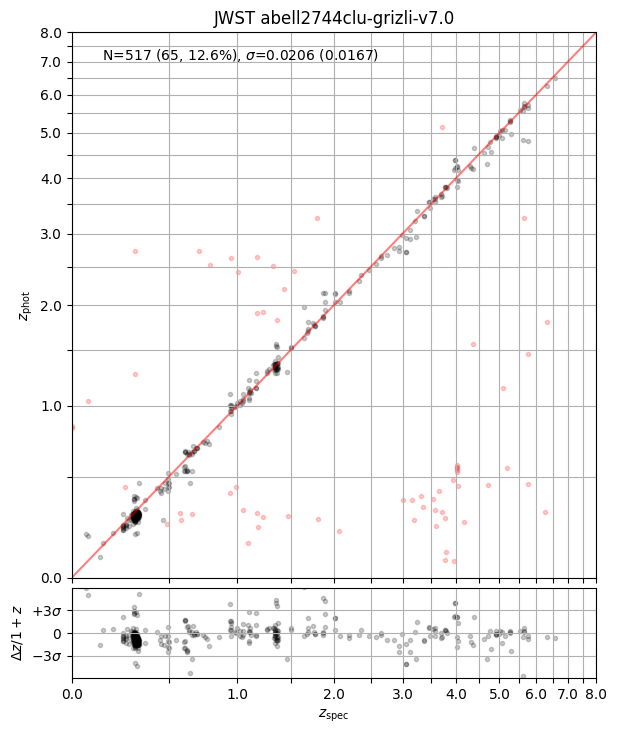

In [18]:
fig = eazy.utils.zphot_zspec(zout['z_phot'], zout['z_spec'], zmax=8)
fig.axes[0].set_title(f'JWST {field}')

In [19]:
#fig = eazy.utils.zphot_zspec(phot['mag_iso'], zout['z_phot'], zmax=8)
mag_f200 = 23.9 - 2.5*np.log10(phot['f200w_tot_1']) # apparent magnitude using zero point of 23.9
mag_f150 = 23.9 - 2.5*np.log10(phot['f150w_tot_1']) # jwst
mag_f160 = 23.9 - 2.5*np.log10(phot['f160w_tot_1']) 
mag_f814 = 23.9 - 2.5*np.log10(phot['f814w_tot_1']) 

# f160-f150 ~ 0
# f200 not masked

In [20]:
np.mean(zout['z_phot'])

2.602345

Text(0.5, 1.0, 'Photometric redshift distribution - Abell 2744')

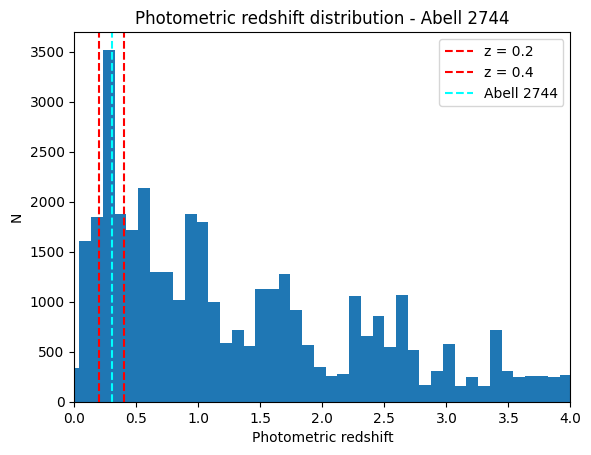

In [21]:
plt.hist(zout['z_phot'], bins=200) # bin this differently
plt.xlim(0, 4)
minl = 0.2
maxl = 0.4
plt.axvline(minl, linestyle='--', color='red', label='z = ' + str(minl))
plt.axvline(maxl, linestyle='--', color='red', label='z = ' + str(maxl))
plt.axvline(0.307, linestyle='--', color='cyan', label='Abell 2744')
plt.legend()
plt.xlabel('Photometric redshift'); plt.ylabel('N'); plt.title('Photometric redshift distribution - Abell 2744')
## Likelihood that a particular galaxy is a cluster member -> galaxies < 0 and > 7.5 are foreground/background objects?

(0.0, 8.0)

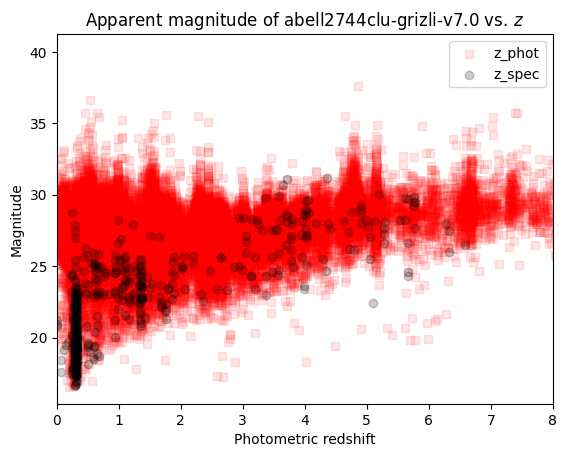

In [22]:
plt.scatter(zout['z_phot'], mag_f200, marker='s', alpha=0.1, label='z_phot', color='red')
plt.scatter(zout['z_spec'], mag_f200, marker='o', alpha=0.2, label='z_spec', color='black')
plt.legend(); plt.title(f'Apparent magnitude of {field} vs. $z$')
plt.ylabel('Magnitude'); plt.xlabel('Photometric redshift')

plt.xlim(0, 8) # based on histogram 

### min/max range to help select cluster members

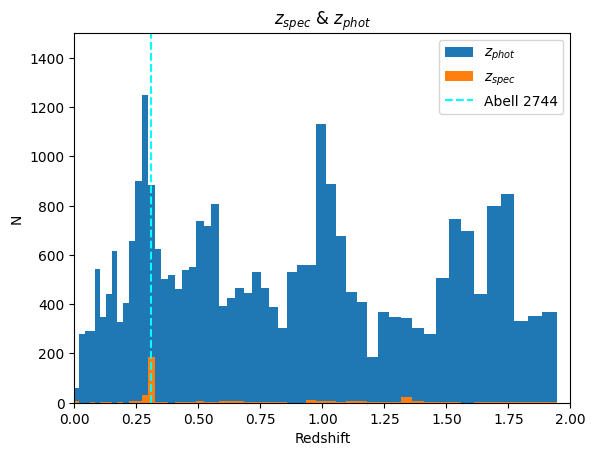

In [23]:
plt.hist(zout['z_phot'], bins=eazy.utils.log_zgrid([0,2], 0.02), label='$z_{phot}$')
plt.hist(zout['z_spec'], bins=eazy.utils.log_zgrid([0,2], 0.02), label='$z_{spec}$') # np.linspace(0, 2, 150) # bin differently
plt.axvline(0.307, linestyle='--', color='cyan', label='Abell 2744')
plt.xlim(0,2); plt.ylim(0, 1500)
plt.xlabel('Redshift'); plt.ylabel('N')
plt.title('$z_{spec}$ vs. $z_{phot}$')
plt.legend()

## Colour-colour diagrams

In [174]:
### USING EAZY
"""
_ubvj = (,,) ->
ubvj_tempfilt = rf integrated template fluxes (total through a filter)
ubvj_lc = rf pivot wavelengths (effective wavelength based on filter's transmission properties)
ubvj = rf fluxes
"""
_ubvj = self.rest_frame_fluxes()
UBVJ = [153,154,155,161] # default UBVJ filters
self.ubvj_tempfilt, self.ubvj_lc, self.ubvj = _ubvj
self.ubvj_f_numbers = UBVJ
      
restU_eazy = self.ubvj[:,0,2] # flux density
restV_eazy = self.ubvj[:,2,2]
restJ_eazy = self.ubvj[:,3,2]

UV_eazy = -2.5*np.log10(restU_eazy/restV_eazy) # rest-frame with AB magnitude
VJ_eazy = -2.5*np.log10(restV_eazy/restJ_eazy)


Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 REST_FRAME/maiz-apellaniz_Johnson_U.res 2006AJ....131.1184M lambda_c= 3.5900e+03 AB-Vega= 0.769 w95=862.3
   1 REST_FRAME/maiz-apellaniz_Johnson_B.res 2006AJ....131.1184M lambda_c= 4.3722e+03 AB-Vega=-0.106 w95=1321.3
   2 REST_FRAME/maiz-apellaniz_Johnson_V.res 2006AJ....131.1184M lambda_c= 5.4794e+03 AB-Vega= 0.002 w95=1369.1
   3 2MASS/J.res lambda_c= 1.2358e+04 AB-Vega= 0.885 w95=2311.1


100%|██████████| 5/5 [07:41<00:00, 92.29s/it] 

 ... rest-frame flux: 461.5 s (n_proc=2,  NOBJ=46957)


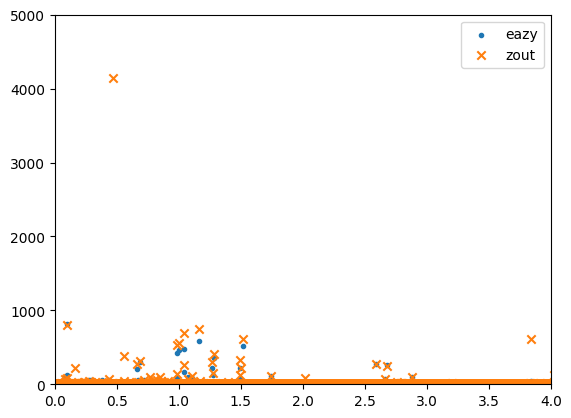

In [201]:
plt.scatter(zout['z_phot'], (restU_eazy), label='eazy', marker='.')
plt.scatter(zout['z_phot'], (restU), label='zout', marker='x')
plt.ylim(0, 5000); plt.xlim(0, 4)
plt.legend()

In [26]:
zout.columns

<TableColumns names=('id','ra','dec','z_spec','nusefilt','z_ml','z_ml_chi2','z_ml_risk','lc_min','lc_max','z_phot','z_phot_chi2','z_phot_risk','z_min_risk','min_risk','z_raw_chi2','raw_chi2','z025','z160','z500','z840','z975','restU','restU_err','restB','restB_err','restV','restV_err','restJ','restJ_err','dL','mass','sfr','Lv','LIR','energy_abs','Lu','Lj','L1400','L2800','LHa','LOIII','LHb','LOII','MLv','Av','lwAgeV','mass_p','sfr_p','Lv_p','LIR_p','energy_abs_p','Lu_p','Lj_p','L1400_p','L2800_p','LHa_p','LOIII_p','LHb_p','LOII_p','Av_p','ssfr_p','rest120','rest120_err','rest121','rest121_err','rest156','rest156_err','rest157','rest157_err','rest158','rest158_err','rest159','rest159_err','rest160','rest160_err','rest414','rest414_err','rest415','rest415_err','rest416','rest416_err')>

In [197]:
restU = zout['restU']
restV = zout['restV']
restJ = zout['restJ']

UV = -2.5*np.log10(restU/restV) # rest-frame with AB magnitude
VJ = -2.5*np.log10(restV/restJ) 

Text(0.5, 1.0, 'UVJ diagram - master')

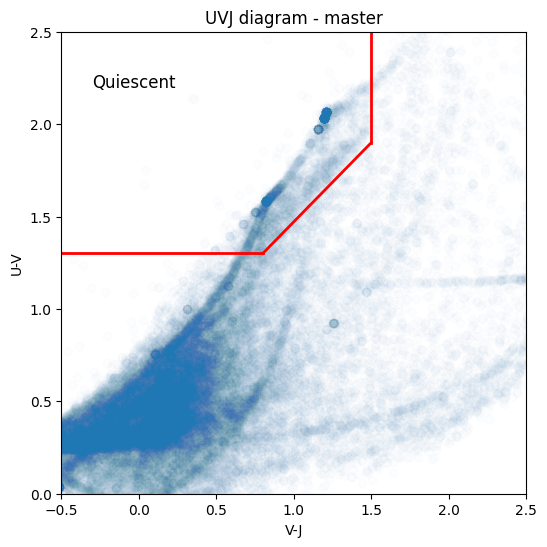

In [31]:
fig, ax = plt.subplots(figsize=(6, 6)) # top left part is quiescent

# lines based on Muzzin 2013
ax.plot([-0.5,0.8],[1.3,1.3],'r',lw=2) # left
ax.plot([0.8,1.5],[1.3,1.9],'r',lw=2) # diag
ax.plot([1.5,1.5],[1.9,2.5],'r',lw=2) # top

plt.scatter(VJ, UV, alpha=0.01)
plt.xlabel('V-J'); plt.ylabel('U-V')
plt.xlim(-0.5, 2.5); plt.ylim(0, 2.5)
ax.text(-0.3,2.2,'Quiescent',fontsize=12)
plt.title('UVJ diagram - master')

# dusty star-forming galaxies are red in V–J, quiescent galaxies are blue in V–J

In [54]:
# Creating a master dataframe of (z, U, V, J) in order to index by redshift
df = pd.DataFrame()

df['z_phot'] = list(zout['z_phot'])
df['U'] = list(restU)
df['V'] = list(restV)
df['J'] = list(restJ)
df['mag'] = mag_f200

df['mag'] = df['mag'].fillna(-1)
df = df[df['mag'] > -1] # only valid ones now

df

,z_phot,U,V,J,mag
10,2.438246,-0.000007,-0.000156,-0.003247,31.106006
11,3.273083,0.026003,0.032111,0.013620,27.145678
12,1.369503,0.053349,0.051153,0.066844,27.071478
13,0.592300,0.213709,0.401163,0.542543,24.457128
14,0.943194,0.007413,0.011538,0.017594,28.059074
...,...,...,...,...,...
47883,3.093199,0.030869,0.045687,0.183679,26.889783
47884,0.732545,0.038687,0.068179,0.077431,26.554224
47885,0.672800,0.318292,1.059566,6.777478,21.795159
47886,0.340983,0.028254,0.042784,0.059217,26.795970


In [83]:
7//2, 2 + 7%2

(3, 3)

In [111]:
def UVJ_diagram(df):
    """ For a given dataframe of shape (z, U, V, J, mag), 
        return the minimum and maximum z and UV and VJ bands
    """
    min_z = min(df['z_phot'])
    max_z = max(df['z_phot'])
    UV = -2.5*np.log10(df['U']/df['V'])
    VJ = -2.5*np.log10(df['V']/df['J'])
    
    return min_z, max_z, VJ, UV

def plot_df_subsets(zs, cut=''):
    """ Subplots for each range of z in zs (also cuts for magnitude if applicable)
    """
    fig, axs = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)
    fig.suptitle('UVJ Diagram - Abell 2744' + ' (' + cut + ')')

    for i, variable in enumerate(zs):
        x = i//2; y = i%2 

        axs[x,y].scatter(UVJ_diagram(zs[i])[2], UVJ_diagram(zs[i])[3], alpha=0.1, marker='*') 
        axs[x,y].set_xlim(-0.5, 2.5); axs[x,y].set_ylim(0, 2.5)
        axs[x,y].text(-0.2, 2.2, str(round(UVJ_diagram(zs[i])[0], 2))+' $\leq$ z $\leq$ '+str(round(UVJ_diagram(zs[i])[1], 2)),fontsize=10)
        axs[x,y].set_xlabel('V-J')
        axs[x,y].set_ylabel('U-V')  

        axs[x,y].grid(alpha=0.7)

        # Plotting lines
        axs[x,y].plot([-0.5,0.8],[1.3,1.3],'r',lw=2) # left
        axs[x,y].plot([0.81,1.5],[1.3,1.9],'r',lw=2) # diag
        axs[x,y].plot([1.5,1.5],[1.9,2.5],'r',lw=2) # top

    plt.tight_layout()
    plt.show()

    return # concentrated cluster galaxies & background galaxies deviating in colour?

3454
3317
3670
3593
3809
3799
56.324172392254845 %


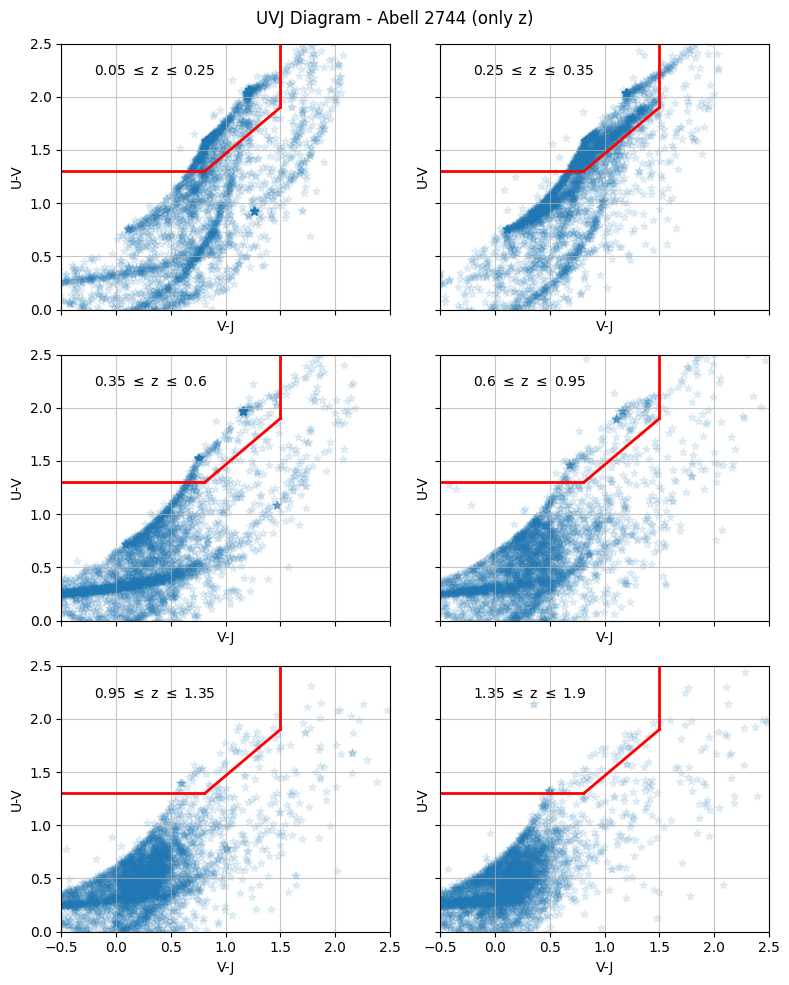

In [112]:
# Creating dataframes for different ranges of redshift

z1 = df[(df['z_phot'] >= 0.05) & (df['z_phot'] <= 0.25)]
z2 = df[(df['z_phot'] > 0.25) & (df['z_phot'] <= 0.35)] # explore more with this one
z3 = df[(df['z_phot'] > 0.35) & (df['z_phot'] <= 0.6)]
z4 = df[(df['z_phot'] > 0.6) & (df['z_phot'] <= 0.95)]
z5 = df[(df['z_phot'] > 0.95) & (df['z_phot'] <= 1.35)]
z6 = df[(df['z_phot'] > 1.35) & (df['z_phot'] <= 1.90)]

zs=[z1,z2,z3,z4 ,z5, z6]

c = 0
for z in zs:
    print(len(z))
    c += (len(z))

print(c / len(df) * 100, '%')

plot_df_subsets(zs, cut='only z')

## Zooming into cluster!

673
439
464
520
610
611
8.632625442431815 %


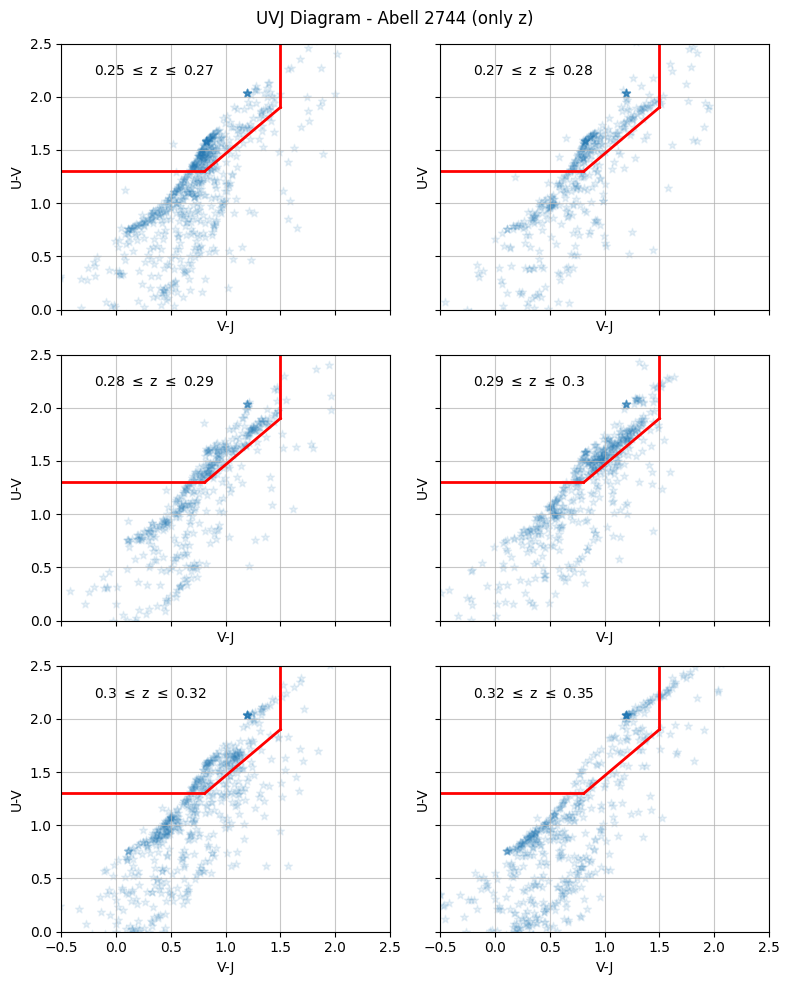

In [113]:
# Creating dataframes for different ranges of redshift

z1 = df[(df['z_phot'] >= 0.25) & (df['z_phot'] <= 0.27)]
z2 = df[(df['z_phot'] > 0.27) & (df['z_phot'] <= 0.28)]
z3 = df[(df['z_phot'] > 0.28) & (df['z_phot'] <= 0.29)]
z4 = df[(df['z_phot'] > 0.29) & (df['z_phot'] <= 0.30)]
z5 = df[(df['z_phot'] > 0.30) & (df['z_phot'] <= 0.32)]
z6 = df[(df['z_phot'] > 0.32) & (df['z_phot'] <= 0.35)]

zs=[z1,z2,z3,z4 ,z5,z6]

c = 0
for z in zs:
    print(len(z))
    c += (len(z))

print(c / len(df) * 100, '%')

plot_df_subsets(zs, cut='only z')

## Magnitude

(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 9.000e+00, 8.000e+00, 8.000e+00, 1.100e+01,
        1.400e+01, 2.000e+01, 2.400e+01, 2.500e+01, 3.300e+01, 4.800e+01,
        4.700e+01, 5.800e+01, 5.800e+01, 5.400e+01, 4.700e+01, 7.600e+01,
        7.400e+01, 9.200e+01, 9.300e+01, 1.210e+02, 1.460e+02, 1.740e+02,
        2.180e+02, 2.370e+02, 1.753e+04, 3.370e+02, 3.570e+02, 4.610e+02,
        4.710e+02, 5.510e+02, 6.060e+02, 6.930e+02, 7.770e+02, 8.490e+02,
        9.590e+02, 1.155e+03, 1.359e+03, 1.517e+03, 1.674e+03, 1.850e+03,
        1.864e+03, 1.813e+03, 1.711e+03, 1.754e+03, 1.509e+03, 1.315e+03,
        1.074e+03, 8.850e+02, 6.760e+02, 5.140e+02, 4.060e+02, 3.380e+02,
        2.560e+02, 1.930e+02, 1.330e+02, 1.280e+02, 8.800e+01, 6.700e+01,
        5.400e+01, 5.700e+01, 4.000e+01, 2.200e+01, 2.200e+01, 1.300e+01,
        1.600e+01, 1.600e+01, 1.600e+0

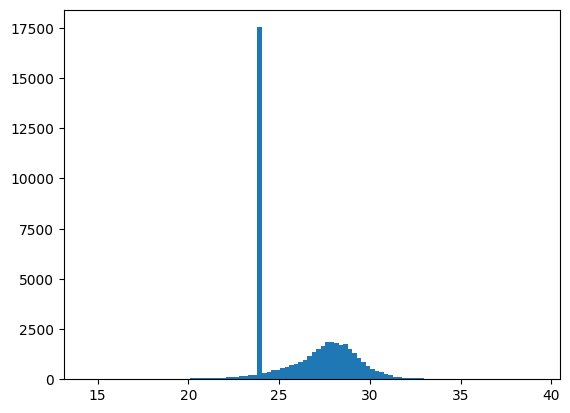

In [117]:
plt.hist(mag_f814, bins=100, label='F200') # weird values check this out

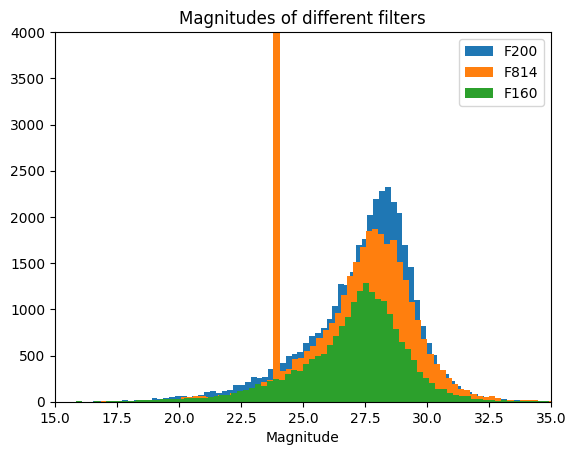

In [118]:
plt.hist(mag_f200, bins=100, label='F200')
plt.hist(mag_f814, bins=100, label='F814') # .filled(0)
plt.hist(mag_f160, bins=100, label='F160')
plt.xlim(15, 35); plt.ylim(0, 4000)
plt.xlabel('Magnitude')
plt.title('Magnitudes of different filters')
plt.legend()


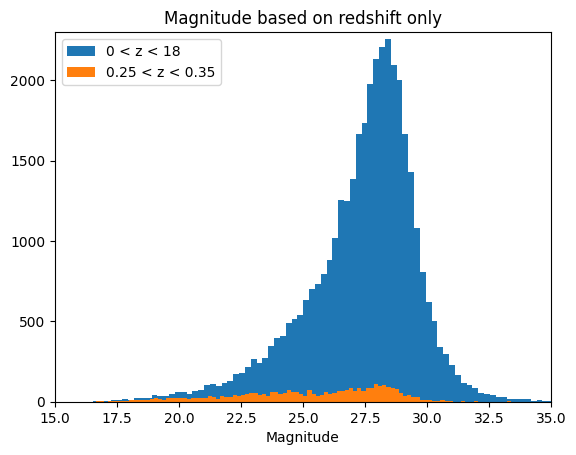

In [119]:
# NO MAGNITUDE BINS:
df_cut =  df[(df['z_phot'] > 0) & (df['z_phot'] <= 18)]
df_cut1 =  df[(df['z_phot'] > 0.25) & (df['z_phot'] <= 0.35)]
              
plt.hist(df_cut['mag'], bins=100, label='0 < z < 18')
plt.hist(df_cut1['mag'], bins=100, label='0.25 < z < 0.35')
plt.xlim(15,35), plt.ylim(0, 2300)
plt.xlabel('Magnitude')
plt.title('Magnitude based on redshift only')

plt.legend()

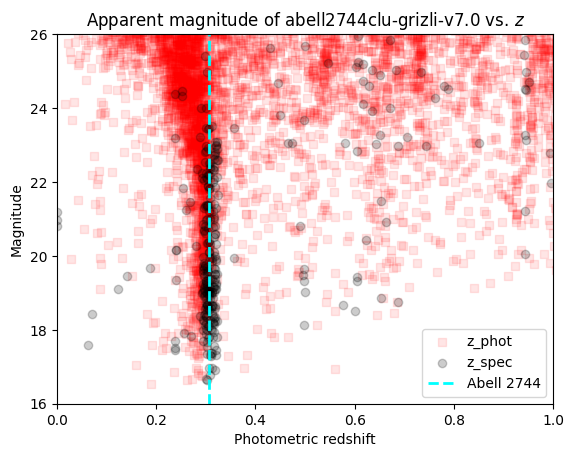

In [106]:
plt.scatter(zout['z_phot'], mag_f200, marker='s', alpha=0.1, label='z_phot', color='red')
plt.scatter(zout['z_spec'], mag_f200, marker='o', alpha=0.2, label='z_spec', color='black')
plt.title(f'Apparent magnitude of {field} vs. $z$')
plt.ylabel('Magnitude'); plt.xlabel('Photometric redshift')

plt.xlim(0, 1); plt.ylim(16, 26)
plt.axvline(0.307, color='cyan', linestyle='--', linewidth=2, label='Abell 2744')
plt.legend()

# make alpha lower to see transparency

### Binning for magnitude - UVJ Diagrams

In [114]:
# Creating dataframes for different ranges of magnitude (on top of redshift)
ms = []

for z in zs:
    m_cut = z[(z['mag'] >= 17) & (z['mag'] <= 23)]
    ms.append(m_cut)

for m in ms:
    print(len(m))

72
83
132
257
165
48


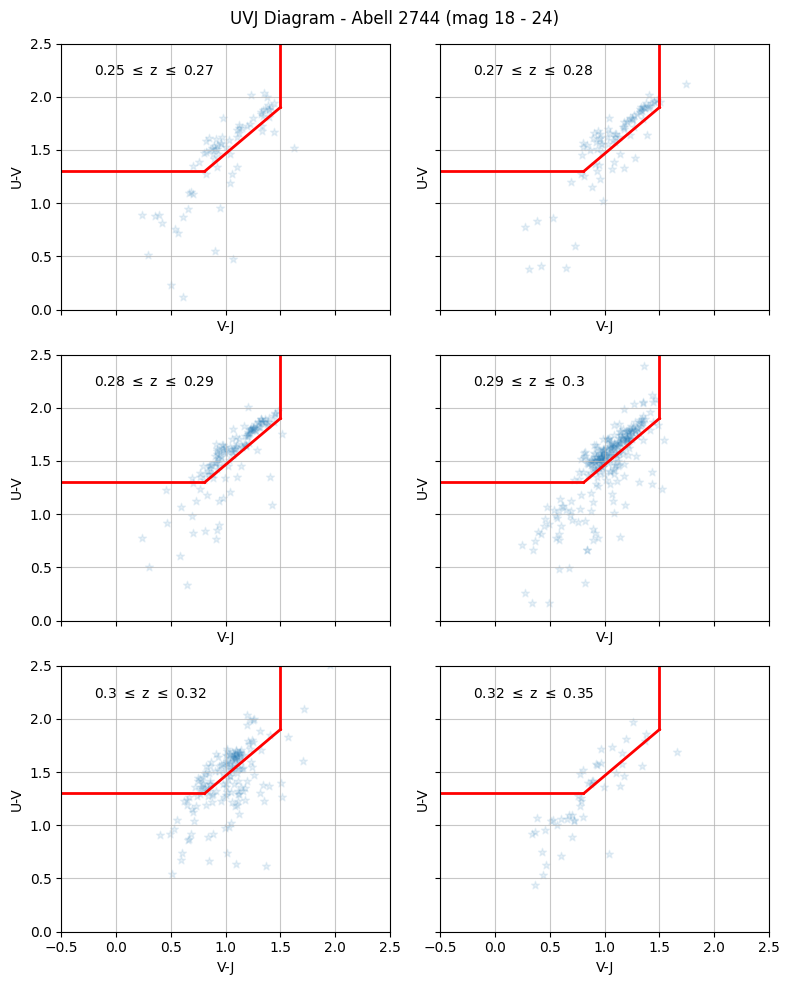

In [115]:
plot_df_subsets(ms, cut='mag 18 - 24') # cut more into ms[2] to see cluster; plot magnitudes by colour

## Luminosity Function

0 11
1 28
2 46
3 53
4 63
5 72
6 74
7 78
8 79
9 81
10 82
11 97
12 99
13 104
14 109
15 135
16 140
17 144
18 161
19 180
20 183
21 185
22 226
23 237
24 241
25 257
26 261
27 265
28 277
29 281
30 282
31 291
32 305
33 309
34 318
35 343
36 344
37 345
38 359
39 365
40 389
41 392
42 393
43 403
44 423
45 434
46 443
47 453
48 463
49 469
50 470
51 471
52 490
53 497
54 508
55 511
56 527
57 534
58 535
59 538
60 545
61 546
62 556
63 560
64 564
65 572
66 575
67 578
68 610
69 611
70 618
71 622
72 630
73 635
74 637
75 638
76 646
77 659
78 661
79 690
80 698
81 699
82 706
83 708
84 721
85 727
86 728
87 780
88 781
89 788
90 792
91 793
92 802
93 810
94 815
95 824
96 831
97 843
98 849
99 851
100 865
101 867
102 872
103 878
104 884
105 886
106 893
107 899
108 903
109 932
110 933
111 935
112 945
113 1000
114 1002
115 1020
116 1032
117 1040
118 1044
119 1047
120 1063
121 1075
122 1078
123 1081
124 1092
125 1097
126 1098
127 1106
128 1117
129 1138
130 1147
131 1165
132 1181
133 1183
134 1210
135 1211
136 1227
137

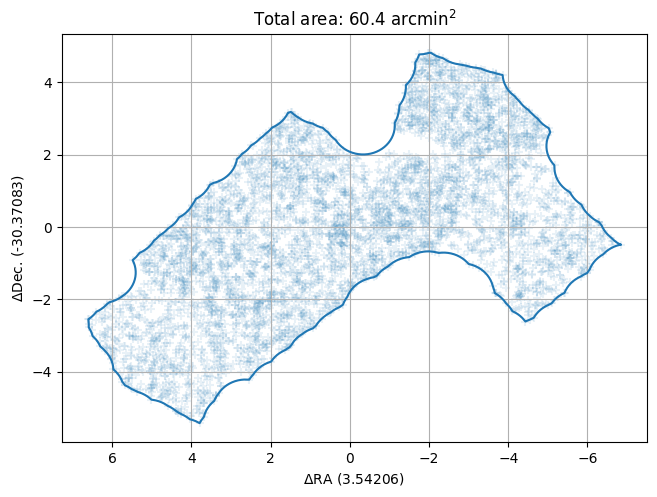

In [152]:
area, area_fig = grizli.utils.catalog_area(phot['ra'], phot['dec']) # square arcminutes

In [155]:
def scale_factor(z1, z2, area):
    """ area should be unitless
    """
    area *=  u.arcmin**2
    area_ster = area.to(u.steradian, equivalencies=u.dimensionless_angles())
    vol_in = WMAP9.comoving_volume(z1)
    vol_out = WMAP9.comoving_volume(z2)
    return np.abs((vol_out-vol_in) / (area_ster / (2 * np.pi)))


In [157]:
scale_f = scale_factor(0.32, 0.30, area)

In [158]:
# Schechter function:
def schechter(mag, scale_factor, M_star=-21.9,a=-1.19,phi_star=11): # use scipy to fit values for m_star, a, phi, also look at literature
    func = scale_factor * 0.4*np.log(10) * phi_star * 10**(-0.4*(mag-M_star)*(a+1)) * np.exp(-10**(-0.4*(mag-M_star)))
    return func

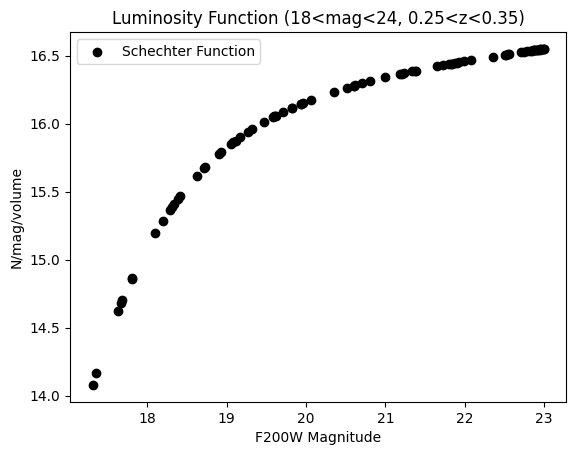

In [171]:
sch = schechter(ms[1]['mag'],scale_f, M_star=19,a=-1.19,phi_star=11)

plt.title('Luminosity Function (18<mag<24, 0.25<z<0.35)')
#plt.hist(ms[1]['mag'], bins=20, label='Magnitude')
plt.scatter(ms[1]['mag'], np.log10(sch), label='Schechter Function', color='k', marker='o')
plt.xlabel('F200W Magnitude'); plt.ylabel('N/mag/volume')
plt.legend()

# y-axis should be N/mag/volume WHYYYYYY

In [ ]:
## do the same bins for gds to compare as the field, except luminosity function